In [1]:
import dipy

In [2]:
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs

In [3]:
from fenics import *
from mshr import *
#from math import pi, sin, cos, sqrt
import math
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import os

In [4]:
fname = 'dMRI_data/ss-ras_data.nii.gz' 
bval_fname = 'dMRI_data/ss-ras.bval' 
bvec_fname = 'dMRI_data/ss-ras.bvec'

data, affine = load_nifti(fname)
bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
print('data.shape (%d, %d, %d, %d)' % data.shape)

data_float = data.astype(np.float32)

dataMaxVal = int(max(data.flatten()))
dataMinVal = int(min(data.flatten()))

#print('b values: ', bvals)
#print('b vectors: ', bvecs)

data.shape (104, 104, 72, 32)


In [5]:
def project_point_onto_affine_subspace(p, V):
    """Projects a point onto an affine subspace

    p.shape = (N,)   OR (num_pts, N) for vectorization over many points / affine subspaces
    V.shape = (k, N) OR (num_pts, k, N) for vectorization

    N = dimension of ambient space
    k-1 = dimension of affine subspace

    For a single point / affine subspace:
        - p is the point in R^N to be projected onto the affine subspace
        - The affine subspace is the set of all affine combinations
        of rows, V[i,:], of the matrix V

    Vectorization:
    For many points / affine subspaces, each point is
    projected onto its corresponding affine subspace
        p[i,:] is the ith point
        V[i,:,:] is the matrix defining the ith affine subspace

    Example usage:
        import numpy as np
        spatial_dim = 3
        p1 = np.random.randn(spatial_dim)
        V1 = np.array([[2., 0., 0.],
                      [2., 1., 0.],
                      [2., 0., 1.]])
        p2 = np.random.randn(spatial_dim)
        V2 = np.array([[0., 3., 0.],
                       [1., 3., 0.],
                       [0., 3., 1.]])
        p = np.stack([p1, p2])
        V = np.stack([V1, V2])
        projected_p, affine_coordinates = project_point_onto_affine_subspace(p, V)
        projected_p1 = projected_p[0,:]
        projected_p2 = projected_p[1,:]
        print('p1=', p1)
        print('projected_p1=', projected_p1)
        print('p2=', p2)
        print('projected_p2=', projected_p2)
    """
    if len(p.shape) == 1:
        PP = p.reshape((1, p.shape[0]))
        VV = V.reshape((1, V.shape[0], V.shape[1]))
    else:
        PP = p
        VV = V
    num_pts, k, N = VV.shape

    if k == 1:
        affine_coordinates = np.ones((num_pts, 1))
    else:
        VV0 = VV[:, 0, :].reshape((num_pts, 1, N))
        dVV = VV[:, 1: :].reshape((num_pts, k-1, N)) - VV0
        dPP = PP.reshape((num_pts, 1, N)) - VV0

        if k == 2:
            PHI = np.sum(dVV * dVV, axis=-1).reshape((num_pts))
            RHS = np.sum(dVV * dPP, axis=-1).reshape((num_pts))
            cc_rest = (RHS / PHI).reshape((num_pts, 1))
        else:
            PHI = np.einsum('xiz,xjz->xij', dVV, dVV) # shape = (num_pts, k-1, k-1)
            iPHI = np.linalg.inv(PHI) # shape = (num_pts, k-1, k-1)

            RHS = np.sum(dVV * dPP, axis=-1)  # shape = (num_pts, k-1)
            cc_rest = np.einsum('pij,pj->pi', iPHI, RHS)  # shape = (num_pts, k-1)

        cc_first = (1. - np.sum(cc_rest, axis=1)).reshape((num_pts, 1))
        affine_coordinates = np.concatenate([cc_first, cc_rest], axis=1) # shape = (num_pts, k)

    PP_projected = np.einsum('pi,pij->pj', affine_coordinates, VV) # shape = (num_pts, N)

    if len(p.shape) == 1:
        PP_projected = PP_projected.reshape(-1)
        affine_coordinates = affine_coordinates.reshape(-1)
    return PP_projected, affine_coordinates

def powerset(s):
    # NOT MY CODE. FROM USER "hughdbrown" ON STACKOVERFLOW HERE:
    # https://stackoverflow.com/a/1482320/484944
    x = len(s)
    masks = [1 << i for i in range(x)]
    for i in range(1 << x):
        yield [ss for mask, ss in zip(masks, s) if i & mask]

def closest_point_on_simplex(p, V):
    """Projects a point onto a simplex (triangle, tetrahedron, etc)

    p.shape = (N,)   OR (num_pts, N) for vectorization over many points/simplices
    V.shape = (k, N) OR (num_pts, k, N) for vectorization

    N = dimension of ambient space
    k-1 = dimension of simplex

    For a single point/simplex:
        - p is the point in R^N to be projected onto the simplex
        - The simplex is the set of all convex combinations
        of rows, V[i,:], of the matrix V

    Vectorization:
    For many points/simplices, each point is
    projected onto its corresponding simplex
        p[i,:] is the ith point
        V[i,:,:] is the matrix defining the ith simplex

    Example usage:
        import numpy as np
        import matplotlib.pyplot as plt
        p1 = np.array([1.1, 0.4])
        V1 = np.array([[0., 0.],
                       [0., 1.],
                       [1., 0.]])
        p2 = np.array([-0.3, 1.1])
        V2 = np.array([[-1.0, 0.],
                       [0.,   0.],
                       [-0.5, 0.5]])
        p = np.stack([p1, p2])
        V = np.stack([V1, V2])
        projected_p = closest_point_on_simplex(p, V)
        projected_p1 = projected_p[0,:]
        projected_p2 = projected_p[1,:]
        plt.figure()
        t1 = plt.Polygon(V1)
        plt.gca().add_patch(t1)
        plt.plot([p1[0], projected_p1[0]],
                 [p1[1], projected_p1[1]], 'r')
        t2 = plt.Polygon(V2)
        plt.gca().add_patch(t2)
        plt.plot([p2[0], projected_p2[0]],
                 [p2[1], projected_p2[1]], 'r')
        plt.gca().set_aspect('equal')
        plt.show()
    """
    if len(p.shape) == 1:
        PP = p.reshape((1, p.shape[0]))
        VV = V.reshape((1, V.shape[0], V.shape[1]))
    else:
        PP = p
        VV = V
    num_pts, k, N = VV.shape

    subsets = list(powerset(list(range(k)))) # e.g., [[], [0], [1], [2], [0,1], [0,2], [1,2], [0,1,2]]
    QQ = list()
    CC = list()
    for s in subsets:
        if s:
            simplicial_facet = VV[:,s,:]
            Q, C = project_point_onto_affine_subspace(PP, simplicial_facet)
            QQ.append(Q)
            CC.append(C)

    distances = np.stack([np.linalg.norm(Q - PP, axis=-1) for Q in QQ]) # shape=(num_facets, num_pts)

    good_inds = np.stack([(np.all(0. <= C, axis=1) & np.all(C <= 1., axis=1)) for C in CC]) # shape=(num_facets, num_pts)
    bad_inds = np.logical_not(good_inds)
    distances[bad_inds] = np.inf
    closest_inds = np.expand_dims(np.argmin(distances[:, :, None], axis=0), axis=0)

    QQ_stack = np.stack(QQ) # shape=(num_facets, num_pts, N)
    PP_projected = np.take_along_axis(QQ_stack, closest_inds, axis=0)[0,:,:]

    if len(p.shape) == 1:
        PP_projected = PP_projected.reshape(-1)
    return PP_projected

def closest_point_in_mesh(p, mesh):
    """Finds the nearest point in a mesh to a given point
    p is the point or points (numpy array)
    mesh is the fenics/dolfin mesh

    p.shape = (N,) OR (num_pts, N) for vectorization over many points
    N = dimension of ambient space

    Example usage:
        import numpy as np
        import dolfin as dl
        import matplotlib.pyplot as plt
        mesh = dl.UnitSquareMesh(13,9)
        num_pts = 20
        p = np.random.randn(num_pts, 2) + np.array([0.5, 0.5])
        closest_p = closest_point_in_mesh(p, mesh)
        plt.figure()
        dl.plot(mesh)
        for ii in range(num_pts):
            plt.plot([p[ii,0], closest_p[ii,0]], [p[ii,1], closest_p[ii,1]], 'b')
            plt.plot(p[ii,0], p[ii,1], '*k')
            plt.plot(closest_p[ii,0], closest_p[ii,1], '.r')
        plt.show()
    """
    if len(p.shape) == 1:
        PP = p[None,:]
    else:
        PP = p
    num_pts, N = PP.shape
    tdim = mesh.topology().dim()
    k = tdim + 1

    VV = np.zeros((num_pts, k, N))
    bbt = mesh.bounding_box_tree()
    for ii in range(num_pts):
        pi = PP[ii,:]
        closest_entity, closest_distance = bbt.compute_closest_entity(Point(pi))
        closest_cell = mesh.cells()[closest_entity]
        vertices_of_closest_cell = mesh.coordinates()[closest_cell, :]
        VV[ii, :, :] = vertices_of_closest_cell

    closest_PP = closest_point_on_simplex(PP, VV)

    if len(p.shape) == 1:
        closest_PP = closest_PP.reshape(-1)
    return closest_PP

In [6]:
#center = Point(0.0, 0.0, 0.0)
#sphere = Sphere(center,1.0)
#mesh = generate_mesh(sphere,20) # 20 specify the resolution of the mesh
#plot(mesh)

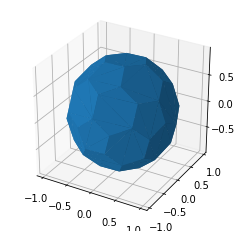

In [7]:
# Mesh and function space
#sphere = Sphere(Point(0.0, 0.0, 0.0), 1.0)
#vmesh = generate_mesh(sphere, 5)
#mesh = BoundaryMesh(vmesh, "exterior")
#plot(mesh)


#mesh = Mesh('LH/mesh_whole_sphere.xml')
#mesh = Mesh('LH/mesh.xml')
mesh = Mesh('LH/mesh_whole_sphere_myself.xml')
plot(mesh)

In [8]:
print(mesh.topology().dim())

3


In [9]:
if has_linear_algebra_backend("Epetra"):
    parameters["linear_algebra_backend"] = "Epetra"

In [20]:
#V = FunctionSpace(mesh, "CG", 2)
V = FunctionSpace(mesh, "P", 1)

# get coordinates of DOFs
dof_coords = V.tabulate_dof_coordinates()
# find nearest DOF:
dof1 = np.argmin(np.linalg.norm(dof_coords - bvecs[1], axis=1))
print('dof {}, x = {}'.format(dof1, dof_coords[dof1]))
dof1_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[1], axis=1))
print('dof {}, x = {}'.format(dof1_sym, dof_coords[dof1_sym]))

dof14 = np.argmin(np.linalg.norm(dof_coords - bvecs[14], axis=1))
print('dof {}, x = {}'.format(dof14, dof_coords[dof14]))
dof14_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[14], axis=1))
print('dof {}, x = {}'.format(dof14_sym, dof_coords[dof14_sym]))

dof17 = np.argmin(np.linalg.norm(dof_coords - bvecs[17], axis=1))
print('dof {}, x = {}'.format(dof17, dof_coords[dof17]))
dof17_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[17], axis=1))
print('dof {}, x = {}'.format(dof17_sym, dof_coords[dof17_sym]))

dof20 = np.argmin(np.linalg.norm(dof_coords - bvecs[20], axis=1))
print('dof {}, x = {}'.format(dof20, dof_coords[dof20]))
dof20_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[20], axis=1))
print('dof {}, x = {}'.format(dof20_sym, dof_coords[dof20_sym]))

dof22 = np.argmin(np.linalg.norm(dof_coords - bvecs[22], axis=1))
print('dof {}, x = {}'.format(dof22, dof_coords[dof22]))
dof22_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[22], axis=1))
print('dof {}, x = {}'.format(dof22_sym, dof_coords[dof22_sym]))

dof29 = np.argmin(np.linalg.norm(dof_coords - bvecs[29], axis=1))
print('dof {}, x = {}'.format(dof29, dof_coords[dof29]))
dof29_sym = np.argmin(np.linalg.norm(dof_coords + bvecs[29], axis=1))
print('dof {}, x = {}'.format(dof29_sym, dof_coords[dof29_sym]))

# now define a DirichletBC at that point
bcs = [DirichletBC(V, Constant(data_float[60,50,56,1]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof1][0], y=dof_coords[dof1][1], z=dof_coords[dof1][2]),
                 'pointwise'),
      DirichletBC(V, Constant(data_float[60,50,56,1]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof1_sym][0], y=dof_coords[dof1_sym][1], z=dof_coords[dof1_sym][2]),
                 'pointwise'),
      
      DirichletBC(V, Constant(data_float[60,50,56,14]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof14][0], y=dof_coords[dof14][1], z=dof_coords[dof14][2]),
                 'pointwise'),
      DirichletBC(V, Constant(data_float[60,50,56,14]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof14_sym][0], y=dof_coords[dof14_sym][1], z=dof_coords[dof14_sym][2]),
                 'pointwise'),
      
      DirichletBC(V, Constant(data_float[60,50,56,17]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof17][0], y=dof_coords[dof17][1], z=dof_coords[dof17][2]),
                 'pointwise'),
      DirichletBC(V, Constant(data_float[60,50,56,17]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof17_sym][0], y=dof_coords[dof17_sym][1], z=dof_coords[dof17_sym][2]),
                 'pointwise'),
      
      DirichletBC(V, Constant(data_float[60,50,56,20]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof20][0], y=dof_coords[dof20][1], z=dof_coords[dof20][2]),
                 'pointwise'),
      DirichletBC(V, Constant(data_float[60,50,56,20]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof20_sym][0], y=dof_coords[dof20_sym][1], z=dof_coords[dof20_sym][2]),
                 'pointwise'),
      
      DirichletBC(V, Constant(data_float[60,50,56,22]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof22][0], y=dof_coords[dof22][1], z=dof_coords[dof22][2]),
                 'pointwise'),
      DirichletBC(V, Constant(data_float[60,50,56,22]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof22_sym][0], y=dof_coords[dof22_sym][1], z=dof_coords[dof22_sym][2]),
                 'pointwise'),
      
      DirichletBC(V, Constant(data_float[60,50,56,29]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof29][0], y=dof_coords[dof29][1], z=dof_coords[dof29][2]),
                 'pointwise'),
      DirichletBC(V, Constant(data_float[60,50,56,29]),
                 'near(x[0], {x}) && near(x[1], {y}) && near(x[2], {z})'.format(x=dof_coords[dof29_sym][0], y=dof_coords[dof29_sym][1], z=dof_coords[dof29_sym][2]),
                 'pointwise'),
     ]

#Test BC
#u_D = Expression('x[0]*x[0] + x[1]*x[1] - 2*x[2]*x[2]', degree=2)
#bcs = [DirichletBC(V, u_D, boundary1, method="pointwise"), 
#       DirichletBC(V, u_D, boundary14, method="pointwise"),
#       DirichletBC(V, u_D, boundary17, method="pointwise"),
#       DirichletBC(V, u_D, boundary20, method="pointwise"),
#       DirichletBC(V, u_D, boundary22, method="pointwise"),
#       DirichletBC(V, u_D, boundary29, method="pointwise"),]

#u = TrialFunction(V) 
#v = TestFunction(V)
##w = Function(V)      

#x = SpatialCoordinate(mesh)
#phi = Expression("atan2(x[1],x[0])", degree=2)
#theta = Expression("acos(x[2]/sqrt(x[0]*x[0]+x[1]*x[1]+x[2]*x[2]))", degree=2)

boundVals = [data_float[60,50,56,1], data_float[60,50,56,14], data_float[60,50,56,17], data_float[60,50,56,20], 
                         data_float[60,50,56,22], data_float[60,50,56,29]] 
print(boundVals)
print(min(boundVals))
lam = min(boundVals)/2.0
print(lam)
#lam = Constant(3.0)

#f = Constant(0.0)


##Weak formulation
#a2 = (Constant(1.0)/sqrt(Constant(1.0) + u.dx(1)*u.dx(1)/lam**2 + u.dx(2)*u.dx(2)/(lam**2*(sin(theta)))))*(u.dx(1)*v.dx(1))
#a3 = (Constant(1.0)/sqrt(Constant(1.0) + u.dx(1)*u.dx(1)/lam**2 + u.dx(2)*u.dx(2)/(lam**2*(sin(theta)))))*(Constant(1.0)/sin(theta)**2)*(u.dx(2)*v.dx(2))
#a4 = (Constant(1.0)/sqrt(Constant(1.0) + u.dx(1)*u.dx(1)/lam**2 + u.dx(2)*u.dx(2)/(lam**2*(sin(theta)))))*(cos(theta)/sin(theta))*u.dx(1)*v
#F = (a2+a3-a4)*dx
#w = Function(V)
## Make functional into a vector function
#F = action(F, w)
## Automatic differentiation
#J = derivative(F, w)
##problem = NonlinearVariationalProblem(F,u,J=derivative(F,w), bcs=bcs)
#problem = NonlinearVariationalProblem(F, w, bcs, J)
## Create solver:
#solver = NonlinearVariationalSolver(problem)
#stype = 'newton'
#solver.parameters['nonlinear_solver']=stype
#sprms = solver.parameters[stype+'_solver']
## Set maximum iterations:
#sprms['maximum_iterations'] = 100
## Force solver to reach maximum iterations for demonstration:
#sprms['relative_tolerance'] = 1e-6
#sprms['absolute_tolerance'] = 1e-6
#sprms["relaxation_parameter"] = 0.2
## Form compiler options
#parameters["form_compiler"]["optimize"]     = True
#parameters["form_compiler"]["cpp_optimize"] = True
#parameters["form_compiler"]["representation"] = "quadrature"
## Print out other available options:
##info(solver.parameters,True)
## Run solver:
#solver.solve()

u = Function(V)
v = TestFunction(V)

#lam = Constant(35.3)
def g(u):
    return Constant(1.0)/sqrt(Constant(1.0) + (grad(u)[0]*grad(u)[0] + grad(u)[1]*grad(u)[1] + grad(u)[2]*grad(u)[2])/lam**2)

#F = inner((Constant(1.0)/sqrt(Constant(1.0) + u.dx(1)*u.dx(1)/lam**2 + u.dx(2)*u.dx(2)/lam**2))*grad(u), grad(v))*dx
F = inner(g(u)*grad(u), grad(v))*dx
# Compute solution
solve(F == 0, u, bcs, solver_parameters={"newton_solver":
                                        {"relative_tolerance": 1e-6}})


dof 54, x = [ 0.22293058 -0.49968055 -0.83703119]
dof 5, x = [-0.22293058  0.49968055  0.83703119]
dof 49, x = [ 0.97062433 -0.19699152  0.13814011]
dof 23, x = [-0.97062433  0.19699152 -0.13814011]
dof 35, x = [-0.02572841 -0.94997877  0.31125325]
dof 19, x = [ 0.02572841  0.94997877 -0.31125325]
dof 42, x = [-0.15568012  0.20317107 -0.96668768]
dof 6, x = [ 0.15568012 -0.20317107  0.96668768]
dof 14, x = [-0.24489762 -0.19681381  0.9493627 ]
dof 53, x = [ 0.24489762  0.19681381 -0.9493627 ]
dof 38, x = [-0.85508788 -0.50734621 -0.106886  ]
dof 28, x = [0.85508788 0.50734621 0.106886  ]
[51.0, 90.0, 92.0, 83.0, 54.0, 106.0]
51.0
25.5
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [21]:
# Save solution to file in VTK format
vtkfile = File('NonLinearIsotropic/solution.pvd')
vtkfile << u

In [22]:
array_u = nodal_values_u = u.vector()
vertex_values_u = u.compute_vertex_values()

In [23]:
print(array_u)

In [24]:
for i in range(len(array_u)):
    print(array_u[i])

-3.9369793542963474e+156
-1.2500707205901032e+156
-6.5660030601004065e+156
-3.056937946131048e+156
5.029207834056895e+155
51.0
83.0
2.4929900888657996e+156
4.970698980470949e+155
-4.1607135591515004e+156
3.5830468296696625e+156
-2.2966482205193795e+156
1.9156316708371746e+156
-3.050690347459316e+155
54.0
-9.190659713327446e+162
3.757846523948676e+156
3.1652333595806783e+156
-4.160713559258014e+156
92.0
7.442858844017144e+156
-2.8949109621836713e+156
4.970698981974068e+155
90.0
9.54046358997763e+155
2.8685636908707593e+158
1.2394549166197605e+156
1.6898409180984558e+158
106.0
1.915631670812468e+156
-6.566003062027836e+156
-2.894910962505374e+156
2.4929900890015774e+156
7.44285884539626e+156
3.1652333600053577e+156
92.0
-1.694577270515398e+155
3.0311499995651498e+156
106.0
1.6898409181227077e+158
2.8685636909109255e+158
9.540463590567974e+155
83.0
-2.1101742118259146e+156
-2.296648221265165e+156
3.583046829681374e+156
3.0311499994900395e+156
-1.6945772746504694e+155
-2.1101742119093154e+

In [27]:
min(array_u)

-9.887238713084082e+162

In [26]:
len(array_u)

60

In [ ]:
#bvecs[1][0]

In [ ]:
#bvecs[1][2]

In [ ]:
data_float[60,50,56,1]

In [ ]:
data_float[60,50,56,14]

In [ ]:
data_float[60,50,56,17]

In [ ]:
data_float[60,50,56,20]

In [ ]:
data_float[60,50,56,22]

In [ ]:
data_float[60,50,56,29]

In [ ]:
#error_L2 = errornorm(u_D, w, 'L2')
#vertex_values_u_D = u_D.compute_vertex_values(mesh)
#vertex_values_u = w.compute_vertex_values(mesh)
#error_max = np.max(np.abs(vertex_values_u_D - vertex_values_u))
#print(error_max)
#print(error_L2)

In [ ]:
#bvecs[27]

In [ ]:
#x_point = Point(*[bvecs[27]])
#mesh.bounding_box_tree().compute_first_entity_collision(x_point)

In [ ]:
#mesh.bounding_box_tree().compute_closest_point(x_point)

In [ ]:
closest_p = closest_point_in_mesh(bvecs[27], mesh)
print(bvecs[27])
print(closest_p)
print(u(closest_p))

In [ ]:
closest_p = closest_point_in_mesh(-bvecs[27], mesh)
print(-bvecs[27])
print(closest_p)
print(u(closest_p))

In [ ]:
array_1 = np.array([[1, 2, 7], [3, 4, 8]])

In [ ]:
array_2 = np.array([[1, 2], [3, 9], [4, 16]]) 

In [ ]:
np.dot(array_1, array_2)